# Machine Learning Modelling: Predicting Startup Funding

In this notebook, I build simple regression models to predict the log of total funding (`log_amount`) for startups based on:

- `founder_count` – number of founders,
- `Founded_year` – year the startup was founded,
- `Stage` – funding stage (Pre-seed, Seed, Series A–F, etc.).

I use two models:

1. Linear Regression (baseline),
2. Random Forest Regressor (more flexible, non-linear model).


## 1. Setup and Data Loading

In this section I import the necessary libraries and load the cleaned dataset
that I prepared during the EDA and hypothesis testing steps. The file
`startupdataset_final_clean_l.csv` already contains the engineered features:

- `founder_count`
- `Amount_clean`
- `log_amount`
- `Founded_year`
- `Stage`


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv("startupdataset_final_clean_l.csv")

# Show a quick preview
df.head(), df.columns



(  Company/Brand  Founded                Sector  \
 0  CollegeDekho   2015.0            E-learning   
 1         Simpl   2015.0     Consumer Services   
 2     PayGlocal   2021.0    Financial Services   
 3     Pocket FM   2018.0                   OTT   
 4   PlanetSpark   2017.0  Education Management   
 
                                         Founder/s Amount(in dollars)  \
 0                                    Ruchir Arora           35000000   
 1                        Nitya, Chaitra Chidanand           40000000   
 2  Prachi Dharani, Rohit Sukhija, Yogesh Lokhande            4900000   
 3         Rohan, Nishanth Srinivas, Prateek Dixit           22000000   
 4                    Maneesh Dhooper, Kunal Malik           13000000   
 
       Stage  Month  founder_count  Amount_clean  log_amount  Founded_year  
 0  Series B     12              1    35000000.0    7.544068        2015.0  
 1  Series B     12              2    40000000.0    7.602060        2015.0  
 2  Series A     12  

## 2. Features, Target, and Train–Test Split

Here I choose the features and the target for modelling:

- **Target**: `log_amount` (log₁₀ of the funding amount).  
- **Features**:
  - `founder_count`
  - `Founded_year`
  - `Stage` (categorical, converted to dummy variables).

I keep only rows where these columns are not missing, and then split the data
into training (80%) and test (20%) sets. The test set is used only for
evaluation to simulate “unseen” startups.


In [2]:
# Columns to use for modelling
features = ["founder_count", "Founded_year", "Stage"]
target = "log_amount"

# Keep only rows with complete information
df_ml = df.dropna(subset=features + [target]).copy()

X_raw = df_ml[features]
y = df_ml[target]
amount = df_ml["Amount_clean"]

# One-hot encode the Stage variable
X = pd.get_dummies(X_raw, columns=["Stage"], drop_first=True)

# Train–test split
X_train, X_test, y_train, y_test, amount_train, amount_test = train_test_split(
    X, y, amount,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


((555, 28), (139, 28))

## 3. Baseline Model: Linear Regression

As a first step, I train a simple Linear Regression model. This model assumes
a linear relationship between the features and `log_amount`.

I evaluate the model using:

- **R²**: how much of the variation in `log_amount` is explained by the model.
- **RMSE** (Root Mean Squared Error) on the log scale: typical size of the
  prediction error in log₁₀ units.


In [3]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred_lin = lin_model.predict(X_test)

r2_lin = r2_score(y_test, y_pred_lin)
mse_lin = mean_squared_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mse_lin)

print(f"Linear Regression - R² (test):  {r2_lin:.3f}")
print(f"Linear Regression - RMSE (log): {rmse_lin:.3f}")


Linear Regression - R² (test):  0.680
Linear Regression - RMSE (log): 0.472


The Random Forest model achieved an R² of about 0.69 on the test set, meaning that the features (founder_count, Stage, Founded_year) together explain roughly 69% of the variation in log funding.
The RMSE on the log₁₀ scale is about 0.47. This corresponds to roughly a
3× difference on the original funding scale (10^0.47 ≈ 3). In practice,
this means that the Random Forest predictions are often within a factor
of about three of the true funding amounts, which is reasonable given
the high variability and noise in startup funding data.


## 4. Main Model: Random Forest Regressor

Next, I train a Random Forest Regressor using the same features. Random Forest
is an ensemble of many decision trees. Each tree learns different splits of the
data, and the final prediction is the average of all trees.

This model can capture non-linear relationships and interactions between
variables, for example between `Stage` and `Founded_year`.

Again, I evaluate the model using R² and RMSE on the test set.


In [4]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=None,
    min_samples_leaf=3,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f"Random Forest - R² (test):  {r2_rf:.3f}")
print(f"Random Forest - RMSE (log): {rmse_rf:.3f}")


Random Forest - R² (test):  0.685
Random Forest - RMSE (log): 0.468


## 5. Model Comparison: Actual vs Predicted (Scatter Plot)

To visually compare the two models, I plot the actual `log_amount` values on
the x-axis and the predicted values on the y-axis.

- Points close to the diagonal line (y = x) represent good predictions.
- If the Random Forest points are closer to this line than the Linear Regression
  points, it suggests a better fit.


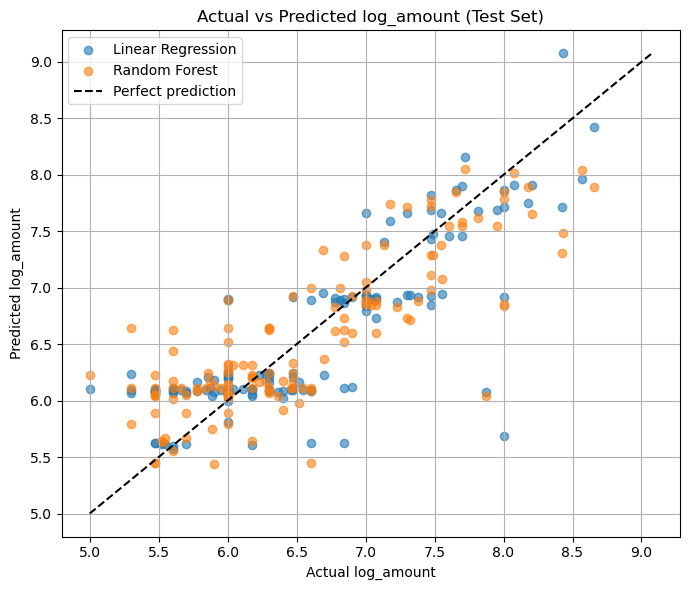

In [5]:
plt.figure(figsize=(7, 6))

plt.scatter(y_test, y_pred_lin, alpha=0.6, label="Linear Regression")
plt.scatter(y_test, y_pred_rf, alpha=0.6, label="Random Forest")

min_val = min(y_test.min(), y_pred_lin.min(), y_pred_rf.min())
max_val = max(y_test.max(), y_pred_lin.max(), y_pred_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], "k--", label="Perfect prediction")

plt.xlabel("Actual log_amount")
plt.ylabel("Predicted log_amount")
plt.title("Actual vs Predicted log_amount (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Feature Importance (Random Forest)

Random Forest allows us to see which features were most important for the
predictions. Higher importance means the feature was used more often to split
the data inside the trees.

This helps to check whether `Stage` dominates the predictions, and how much
additional information `founder_count` and `Founded_year` provide.


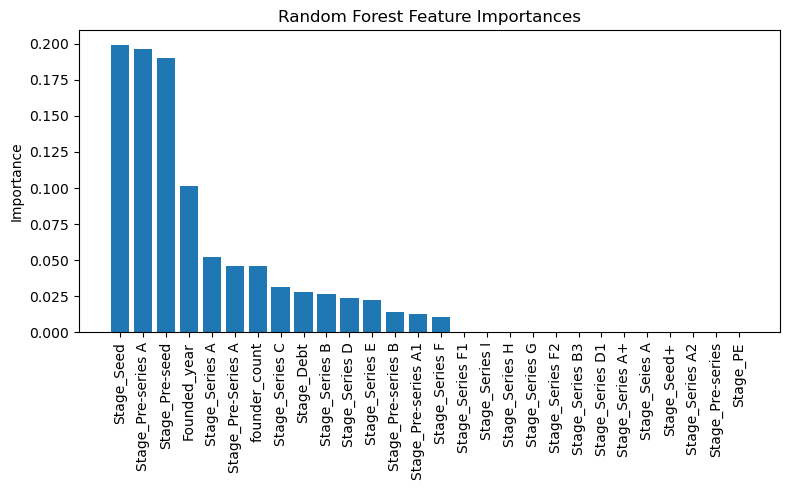

In [6]:
importances = rf_model.feature_importances_
feature_names = X.columns

idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(importances)), importances[idx])
plt.xticks(range(len(importances)), feature_names[idx], rotation=90)
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


## 7. Saving Predictions

Finally, I save the Random Forest predictions for the test set into a CSV file.
This file includes the company name, the true `log_amount`, and the predicted
`log_amount`. It can be used later for inspection or reporting.

The file is called: `ml_predictions_random_forest.csv`.


In [9]:
pred_df = df_ml.loc[X_test.index, ["Company/Brand"]].copy()

pred_df["log_amount_actual"] = y_test.values
pred_df["log_amount_predicted"] = y_pred_rf

# → 2 ondalığa yuvarla
pred_df["log_amount_actual"] = pred_df["log_amount_actual"].round(2)
pred_df["log_amount_predicted"] = pred_df["log_amount_predicted"].round(2)

pred_df.to_csv("ml_predict_random_forest.csv", index=False)
print("Saved: ml_predict_random_forest.csv")
pred_df.head()


Saved: ml_predict_random_forest.csv


,Company/Brand,log_amount_actual,log_amount_predicted
382,Uvi Health,5.52,5.64
667,Udayy,6.40,6.18
257,HomeLane,7.70,7.58
339,Pixuate,6.00,6.27
320,Kenko Health,6.23,6.16
